![OpenSARlab notebook banner](NotebookAddons/blackboard-banner.png)

# An Introduction to Simple SAR Change Detection Methods

### Franz J Meyer; University of Alaska Fairbanks 

<img src="NotebookAddons/UAFLogo_A_647.png" style="padding:5px;" width="170" align="right"/>

This notebook introduces you to a some popular change detection methods that can be applied on SAR time series data. SAR is an excellent tool for change detection. As SAR sensors are weather and illumination independent, and as SAR's carry their own illumination source (active sensor), differences between repeated images are a direct indication of changes on the surface. This fact is exploited by the change detection methods introduced below. 
    
The exercise is done in the framework of *Jupyter Notebooks*. The Jupyter Notebook environment is easy to launch in any web browser for interactive data exploration with provided or new training data. Notebooks are comprised of text written in a combination of executable python code and markdown formatting including latex style mathematical equations. Another advantage of Jupyter Notebooks is that they can easily be expanded, changed, and shared with new data sets or newly available time series steps. Therefore, they provide an excellent basis for collaborative and repeatable data analysis.

**This notebook covers the following data analysis concepts:**

- Time series metrics  95$^{th}$ and 5$^{th}$ percentile difference thresholding
- Time series coefficient of variation thresholding
- Log Ratio-based change detection from image pairs

---
**Important Note about JupyterHub**

Your JupyterHub server will automatically shutdown when left idle for more than 1 hour. Your notebooks will not be lost but you will have to restart their kernels and re-run them from the beginning. You will not be able to seamlessly continue running a partially run notebook.

In [1]:
import url_widget as url_w
notebookUrl = url_w.URLWidget()
display(notebookUrl)

URLWidget()

In [2]:
from IPython.display import Markdown
from IPython.display import display

notebookUrl = notebookUrl.value
user = !echo $JUPYTERHUB_USER
env = !echo $CONDA_PREFIX
if env[0] == '':
    env[0] = 'Python 3 (base)'
if env[0] != '/home/jovyan/.local/envs/rtc_analysis':
    display(Markdown(f'<text style=color:red><strong>WARNING:</strong></text>'))
    display(Markdown(f'<text style=color:red>This notebook should be run using the "rtc_analysis" conda environment.</text>'))
    display(Markdown(f'<text style=color:red>It is currently using the "{env[0].split("/")[-1]}" environment.</text>'))
    display(Markdown(f'<text style=color:red>Select the "rtc_analysis" from the "Change Kernel" submenu of the "Kernel" menu.</text>'))
    display(Markdown(f'<text style=color:red>If the "rtc_analysis" environment is not present, use <a href="{notebookUrl.split("/user")[0]}/user/{user[0]}/notebooks/conda_environments/Create_OSL_Conda_Environments.ipynb"> Create_OSL_Conda_Environments.ipynb </a> to create it.</text>'))
    display(Markdown(f'<text style=color:red>Note that you must restart your server after creating a new environment before it is usable by notebooks.</text>'))

<hr>
<font face="Calibri">

<font size="5"> <b> 0. Importing Relevant Python Packages </b> </font>

<font size="3">In this notebook we will use the following scientific libraries:
<ol type="1">
    <li> <b><a href="https://pandas.pydata.org/" target="_blank">Pandas</a></b> is a Python library that provides high-level data structures and a vast variety of tools for analysis. The great feature of this package is the ability to translate rather complex operations with data into one or two commands. Pandas contains many built-in methods for filtering and combining data, as well as the time-series functionality. </li>
    <li> <b><a href="https://www.gdal.org/" target="_blank">GDAL</a></b> is a software library for reading and writing raster and vector geospatial data formats. It includes a collection of programs tailored for geospatial data processing. Most modern GIS systems (such as ArcGIS or QGIS) use GDAL in the background.</li>
    <li> <b><a href="http://www.numpy.org/" target="_blank">NumPy</a></b> is one of the principal packages for scientific applications of Python. It is intended for processing large multidimensional arrays and matrices, and an extensive collection of high-level mathematical functions and implemented methods makes it possible to perform various operations with these objects. </li>
    <li> <b><a href="https://matplotlib.org/index.html" target="_blank">Matplotlib</a></b> is a low-level library for creating two-dimensional diagrams and graphs. With its help, you can build diverse charts, from histograms and scatterplots to non-Cartesian coordinates graphs. Moreover, many popular plotting libraries are designed to work in conjunction with matplotlib. </li>
    <li> The <b><a href="https://www.pydoc.io/pypi/asf-hyp3-1.1.1/index.html" target="_blank">asf-hyp3 API</a></b> provides useful functions and scripts for accessing and processing SAR data via the Alaska Satellite Facility's Hybrid Pluggable Processing Pipeline, or HyP3 (pronounced "hype"). </li>
<li><b><a href="https://www.scipy.org/about.html" target="_blank">SciPY</a></b> is a library that provides functions for numerical integration, interpolation, optimization, linear algebra and statistics. </li>

</font>

<font face="Calibri" size="3"> Our first step is to <b>import them:</b> </font>

In [3]:
%%capture
from pathlib import Path
from os import system
import datetime # for date
import re

import pandas as pd # for DatetimeIndex
from osgeo import gdal # for Info

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import rc
import numpy as np

from ipyfilechooser import FileChooser

from IPython.display import HTML

import opensarlab_lib as asfn
asfn.jupytertheme_matplotlib_format()

## 1. Load Data Stack

In the Exercise4A-SARChangeDetectionMethods.ipynb notebook will used a dense 12-day repeat Sentinel-1 C-band SAR data stack. It contained imagery acquired during the year 2018 in Guatemala. The data was already prepared for you. Now, you will later learn how to download and pre-process Sentinel-1 images using the services of the [Alaska Satellite Facility](https://www.asf.alaska.edu/). 

**Begin by writing a function to retrieve the absolute paths to each of our tiffs:**

In [4]:
def get_tiff_paths(paths):
    tiff_paths = !ls $paths | sort -t_ -k5,5
    return tiff_paths

**Select the directory holding your tiffs**
- Click the `Select` button
- Navigate to your data directory
- Click the `Select` button
- Confirm that the desired path appears in green text
- Click the `Change` button to alter your selection

In [5]:
fc = FileChooser('/home/jovyan/notebooks')
display(fc)

FileChooser(path='/home/jovyan/notebooks', filename='', title='', show_hidden=False, select_desc='Select', cha…

**Determine the path to the analysis directory containing the tiff directory:**

In [6]:
tiff_dir = Path(fc.selected_path)
analysis_dir = tiff_dir.parent
print(f"analysis_dir: {analysis_dir}")

paths = tiff_dir/"*.tif*"
tiff_paths = get_tiff_paths(paths)

analysis_dir: /home/jovyan/notebooks/SAR_Training/English/Master/northern_ireland


**Determine the path to the analysis directory containing the tiff directory:**

In [7]:
polarity = asfn.select_parameter(['VV', 'VH'], 'Polarity:')
polarity

RadioButtons(description='Polarity:', layout=Layout(min_width='800px'), options=('VV', 'VH'), value='VV')

In [8]:
pol = polarity.value
print(f'Polarity: {pol}')

Polarity: VV


**Create a wildcard path to the tiffs:**

In [9]:
if pol == 'VV':
    wildcard_path = f"{tiff_dir}/*VV.tif*"
else:
    wildcard_path = f"{tiff_dir}/*VH.tif*"
print(f'wildcard_path: \n{wildcard_path}')

wildcard_path: 
/home/jovyan/notebooks/SAR_Training/English/Master/northern_ireland/test_op1/*VV.tif*


**Write a function to extract the tiff dates from a wildcard path.**

In [10]:
def get_dates(paths, file_ext):
    dates = []
    pths = paths.rglob(file_ext)
    
    for p in pths:
        regex = "[^\W_][0-9]{7}"
        date = re.search(regex, str(p))
        if date:
            dates.append(date.group(0))  
              
    dates.sort()
    return dates

**Call get_dates() to collect the product acquisition dates:**

In [11]:
file_ext = None
if pol == 'VV':
    file_ext = f'*VV.tif*'
else:
    file_ext = f'*VH.tif*'

dates = get_dates(tiff_dir, file_ext)
print(f'dates: \n{dates}')

dates: 
['20211022', '20211103', '20211115', '20211127', '20211209', '20211221']


## 2. Create the VRTs

**Create the virtual raster table for the GeoTiffs:**

In [12]:
raster_path = f"{analysis_dir}/raster_stack_{pol}.vrt"
!gdalbuildvrt -separate $raster_path $wildcard_path

0...10...20...30...40...50...60...70...80...90...100 - done.


## 3. Define Some Python Helper Functions for this Notebook

We are defining two helper functions for this notebook:

- **CreateGeoTiff()** to write out images
- **timeseries_metrics()** to compute various metrics from a time series data stack

In [13]:
def create_geotiff(name, array, data_type, ndv, bandnames=None, 
                   ref_image=None, geo_t=None, projection=None):
    # If it's a 2D image we fake a third dimension:
    if len(array.shape) == 2:
        array = np.array([array])
    if ref_image == None and (geo_t == None or projection == None):
        raise RuntimeWarning('ref_image or settings required.')
    if bandnames != None:
        if len(bandnames) != array.shape[0]:
            raise RuntimeError(f'Need {Array.shape[0]} bandnames. {len(bandnames)} given')
    else:
        bandnames = [f'Band {i+1}' for i in range(array.shape[0])]
    if ref_image != None:
        refimg = gdal.Open(ref_image)
        geo_t = refimg.GetGeoTransform()
        Projection = refimg.GetProjection()
    driver = gdal.GetDriverByName('GTIFF')
    array[np.isnan(array)] = ndv
    dataset = driver.Create(name, array.shape[2], array.shape[1], 
                            array.shape[0], data_type)
    dataset.SetGeoTransform(geo_t)
    dataset.SetProjection(projection)
    for i, image in enumerate(array, 1):
        dataset.GetRasterBand(i).WriteArray(image)
        dataset.GetRasterBand(i).SetNoDataValue(ndv)
        dataset.SetDescription(bandnames[i-1])
    dataset.FlushCache()
    return name

In [14]:
def timeseries_metrics(raster, ndv=np.nan):     
    # Make us of numpy nan functions
    # Check if type is a float array
    if not raster.dtype.name.find('float')>-1:
        raster = raster.astype(np.float64)
    # Set ndv to nan
    if not np.isnan(ndv):
        raster[np.equal(raster,ndv)] = np.nan
    # Build dictionary of the metrics
    tsmetrics={}
    rperc = np.nanpercentile(raster,[5,50,95], axis=0)
    tsmetrics['mean'] = np.nanmean(raster, axis=0)
    tsmetrics['max'] = np.nanmax(raster, axis=0)
    tsmetrics['min'] = np.nanmin(raster, axis=0)
    tsmetrics['range'] = tsmetrics['max'] - tsmetrics['min']
    tsmetrics['median'] = rperc[1]
    tsmetrics['p5'] = rperc[0]
    tsmetrics['p95'] = rperc[2]
    tsmetrics['prange'] = rperc[2]-rperc[0]
    tsmetrics['var'] = np.nanvar(raster, axis=0)
    tsmetrics['std'] = np.sqrt(tsmetrics['var'])
    tsmetrics['CV'] = np.abs(tsmetrics['var'] / tsmetrics['mean'])
    return tsmetrics

## 4. Create a Pandas Time Index and Display the VRT Band Dates

**Create an index of timedelta64 data with Pandas:**

In [15]:
tindex = pd.DatetimeIndex(dates)

**Print the bands and dates for all images in the virtual raster table (VRT):**

In [16]:
j = 1
print(f"Bands and dates for {raster_path}")
for i in tindex:
    print("{:4d} {}".format(j, i.date()), end=' ')
    j += 1
    if j%5 == 1:
        print()

Bands and dates for /home/jovyan/notebooks/SAR_Training/English/Master/northern_ireland/raster_stack_VV.vrt
   1 2021-10-22    2 2021-11-03    3 2021-11-15    4 2021-11-27    5 2021-12-09 
   6 2021-12-21 

---
## 4. Create a Time Series Animation to get an Idea of the Dynamics at the Site

### 4.1 Load Time Series Stack

Now we are ready to create a time series animation from the calibrated SAR data.

**First, create a raster from band 0 and a raster stack from all the images:**

In [17]:
img = gdal.Open(raster_path)
band = img.GetRasterBand(1)
raster0 = band.ReadAsArray()
band_number = 0 # Needed for updates
rasterstack = img.ReadAsArray()

**Print the bands, pixels, and lines:**

In [18]:
print(f"Number of  bands: {img.RasterCount}")
print(f"Number of pixels: {img.RasterXSize}")
print(f"Number of  lines: {img.RasterYSize}")

Number of  bands: 6
Number of pixels: 4996
Number of  lines: 1375


## 4.2 Data Conversion between dB and Power Scales

The data at hand are radiometrically terrain corrected images, which are often expressed as terrain flattened $\gamma^0$ backscattering coefficients. For forest and land cover monitoring applications $\gamma^0$ is the preferred metric.

To use a logarithmic scale instead of the natural power scale, **you can set the following variable to True:**

In [19]:
todB = True

labeldB = 'dB' if todB else 'linear'

def convert(raster, todB=todB):
    if todB:
        return 10 * np.ma.log10(raster)
    else:
        return raster

## 4.3 Create Time Series Animation

**Create and move into a directory in which to store our plots and animations:**

In [20]:
product_path = analysis_dir/f'plots_and_animations'

if not product_path.exists():
    print(f'{product_path} created')
    product_path.mkdir()

Now we can **create the information needed to animate our data:**

In [21]:
%%capture 
fig = plt.figure(figsize=(10, 5))
ax = fig.subplots()
ax.axis('off')

copyRaster = np.copy(convert(rasterstack))
vmin = np.nanpercentile(copyRaster, 1)
vmax = np.nanpercentile(copyRaster, 99)
# vmin = np.nanpercentile(convert(rasterstack), 1)
# vmax = np.nanpercentile(convert(rasterstack), 99)

im = ax.imshow(convert(raster0), cmap='inferno', vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im)
cbar.set_label(labeldB)
ax.set_title("{}".format(tindex[0].date()))
plt.rcParams.update({'font.size': 14})

def animate(i):
    ax.set_title("{}".format(tindex[i].date()))
    im.set_data(convert(rasterstack[i]))

# Interval is given in milliseconds
ani = animation.FuncAnimation(fig, animate, frames=rasterstack.shape[0], interval=300)

**Configure matplotlib's RC settings for the animation:**

In [22]:
rc('animation', embed_limit=40971520.0)  # We need to increase the limit maybe to show the entire animation

**Create a javascript animation of the time-series running inline in the notebook:**

In [23]:
HTML(ani.to_jshtml())

**Delete the dummy png that was saved to the current working directory while generating the javascript animation in the last code cell.**

In [24]:
try:
    Path('/home/jovyan/notebooks/SAR_Training/English/Master/None0000000.png').unlink()
except FileNotFoundError:
    pass

**Save the animation (animation.gif):**

In [25]:
ani.save(product_path/f'animation_{labeldB}.gif', writer='pillow', fps=2)

---
## 5. Computation and Visualization of Time Series Metrics

Once a time-series was constructed, we can compute **a set of metrics** for each pixel in the stack:

- Mean 
- Median
- Maximum
- Minimum
- Range (Maximum - Minimum)
- 5th Percentile
- 95th Percentile
- PRange (95th - 5th Percentile)
- Variance
- Coefficient of Variation (Variance/Mean)

---
First, we **mask out pixels** that are zero (e.g. beyond the edge of the swath). Then we **calculate the time series metrics:**

In [26]:
mask = (rasterstack == 0)
raster = np.ma.array(convert(rasterstack), mask=mask, dtype=np.float64)

In [27]:
%%capture
metrics = timeseries_metrics(raster.filled(np.nan), ndv=np.nan)

In [28]:
metrics.keys()

dict_keys(['mean', 'max', 'min', 'range', 'median', 'p5', 'p95', 'prange', 'var', 'std', 'CV'])

Let's look at the histograms for the time series variance and coeficient of variation to aid displaying those images:

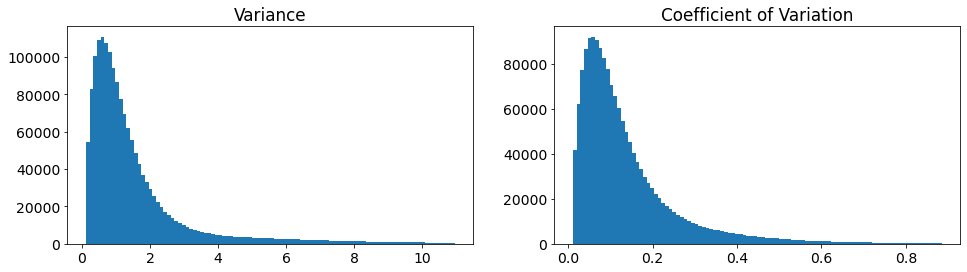

In [29]:
fig, ax = plt.subplots(1,2,figsize=(16,4))
ax[0].hist(metrics['var'].flatten(), bins=100, range=np.nanpercentile(metrics['var'], [1,99]))
ax[1].hist(metrics['CV'].flatten(), bins=100, range=np.nanpercentile(metrics['CV'], [1,99]))
_ = ax[0].set_title('Variance')
_ = ax[1].set_title('Coefficient of Variation')

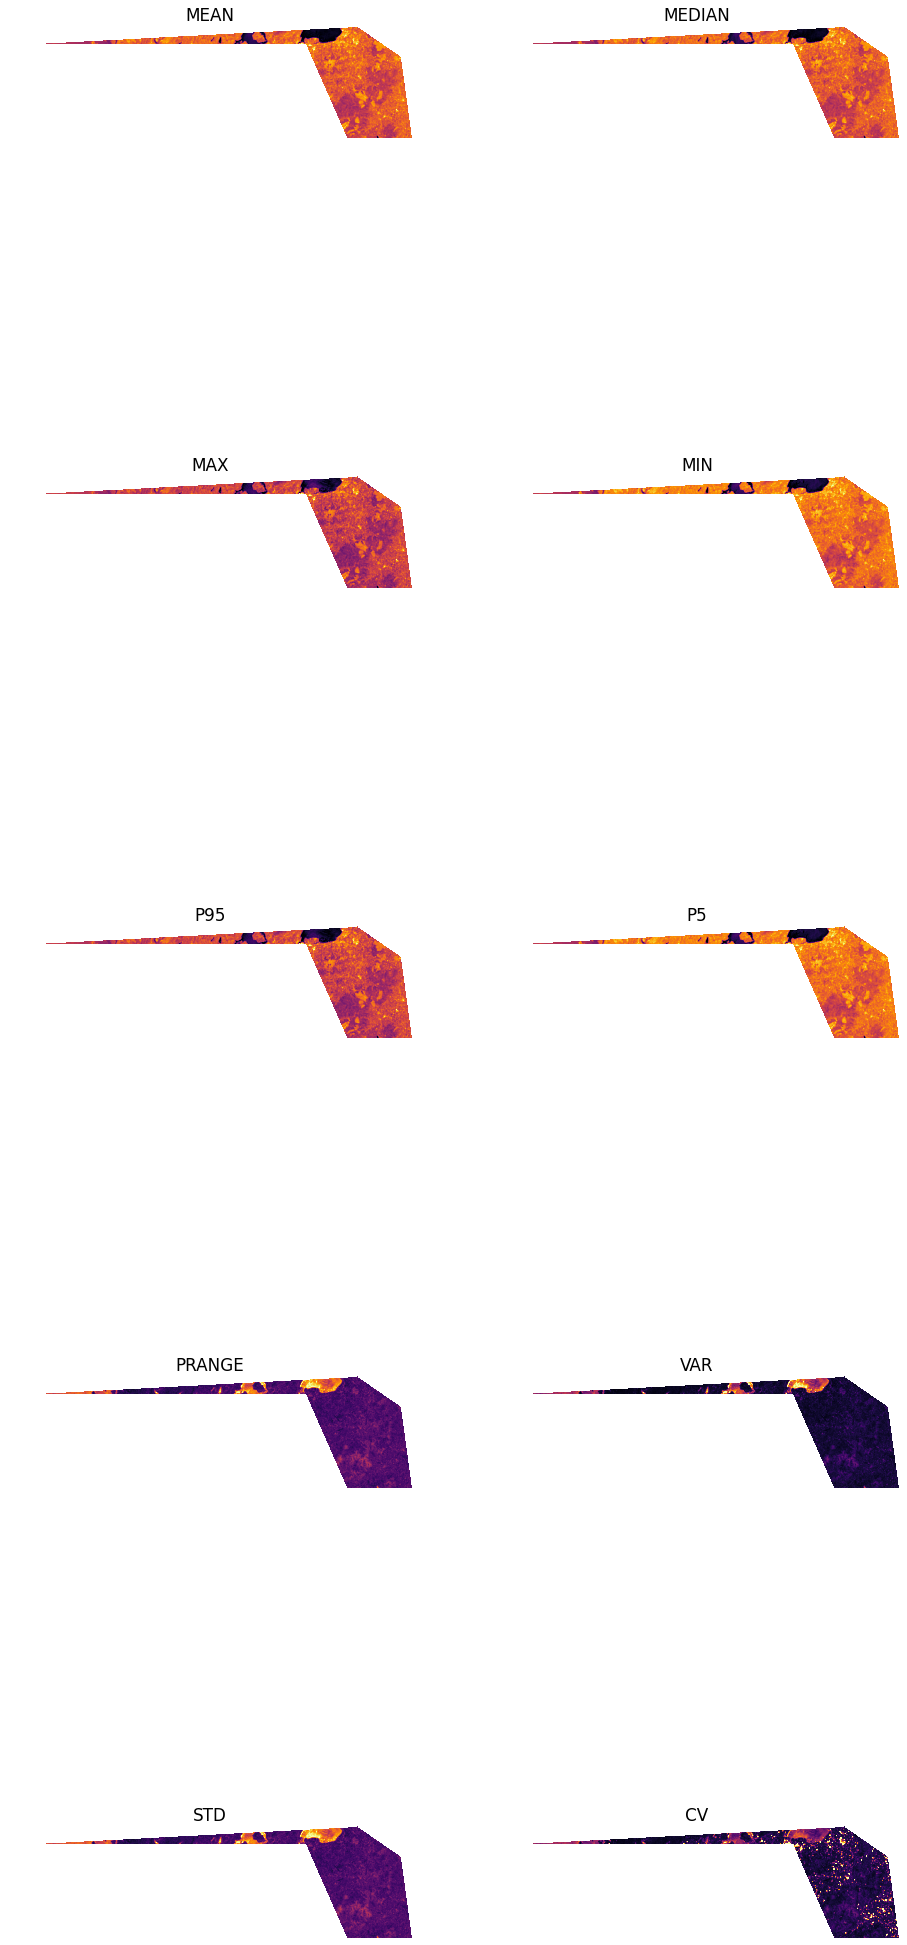

In [30]:
# List the metrics keys you want to plot
metric_keys=['mean', 'median', 'max', 'min', 
             'p95', 'p5', 'prange', 'var', 'std', 'CV']
fig= plt.figure(figsize=(16,40))
idx=1
for i in metric_keys:
    ax = fig.add_subplot(5,2,idx)
    vmin, vmax = np.nanpercentile(metrics[i], [1, 99])
    ax.imshow(metrics[i],vmin=vmin,vmax=vmax,cmap='inferno')
    ax.set_title(i.upper())
    ax.axis('off')
    idx+=1

You might have noticed white patches in the images above. These do not contain any data. The reason is that they are in the radar shadow of terrain that is closer to the satellite.

---

## 6. Some Popular SAR Change Detection Methods

This section will introduce you to the following popular and simple change detection methods:

- Time series metrics  95$^{th}$ and 5$^{th}$ percentile difference and standard deviation thresholding
- Time series coefficient of variation thresholding

---
### 6.1 Change Detection with the Percentile Difference and the Variance Threshold Method

In this method we find thresholds on the **95$^{th}$ and 5$^{th}$ percentile difference** or the **temporal pixel-by-pixel gray value cariance**. Let's start with the 95$^{th}$ and 5$^{th}$ percentile difference. The advantage to look at percentiles verus maximum minus minimum is that it is more robust to outliers.

First, let us define a **function for plotting histograms:**

In [31]:
def plot_histogram_cdf(metric='std'):
    plt.rcParams.update({'font.size': 12})
    fig = plt.figure(figsize=(14, 4)) # Initialize figure with a size
    ax1 = fig.add_subplot(121)  # 121 determines: 2 rows, 2 plots, first plot
    ax2 = fig.add_subplot(122)

    h = ax1.hist(
        metrics[metric].flatten(), bins=200, range=np.nanpercentile(metrics[metric], [1, 99]))
    ax1.xaxis.set_label_text(f'{metric} {labeldB}')
    ax1.set_title('Histogram')

    n, bins, patches = ax2.hist(
        metrics[metric].flatten(), bins=200, range=np.nanpercentile(metrics[metric], [1, 99]),
        cumulative='True', density='True', histtype='step', label='Empirical')
    ax2.xaxis.set_label_text(f'{metric} {labeldB}')
    ax2.set_title('CDF')

    outind = np.where(n > 0.95)
    threshind = np.min(outind)
    thresh = bins[threshind]
    ax1.axvline(thresh,color='red')
    _ = ax2.axvline(thresh,color='red')
    plt.savefig(product_path/f'{metric}_{labeldB}_histogram.png',
                dpi=200, transparent='true')

**Now let's look at the 95th - 5th percentile range**

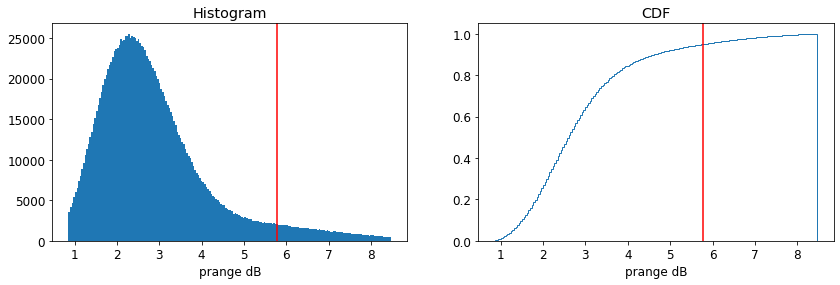

In [32]:
plot_histogram_cdf(metric='prange')

Let's visualize the 5% of all pixels with the largest (95th - 5th percentile) difference in the time series. We will refer to the pixels (x,y) that exceed this threshold $t$ as likely **change pixels (cp):**

${cp}_{x,y} = P_{x,y}^{95th} - P_{x,y}^{5th} > t$ 

If we define $t$ to correspond to the 5% of pixels with highest (95th - 5th percentile) difference, the image looks like:

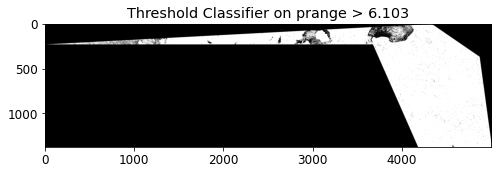

In [33]:
def plot_threshold_classifier(metric='prange', percentage_cutoff=5):
    plt.figure(figsize=(8,8))
    thresh = np.nanpercentile(metrics[metric], 100 - percentage_cutoff)
    mask = metrics[metric] < thresh # For display we prepare the inverse mask
    plt.imshow(mask, cmap='gray')
    _=plt.title(f'Threshold Classifier on {metric} > %1.3f' % thresh)
    plt.savefig(product_path/f'changes_{metric}_{labeldB}.png',
            dpi=200, transparent='true')
    return np.logical_not(mask)

metric = 'prange'
masks = {metric: plot_threshold_classifier(metric=metric)}

Instead of applying a threshold on the 95th - 5th percentile difference data, we can also attempt to threshold other metrics. The **standard deviation** (or variance) variable seems a useful indicator for change as it identifies pixels for which radar brightness has changed strongly within the time series. Hence, in the following we use this metric for change identification according to:

${cp}_{x,y} = \sigma > t$ 

with $t=CDF_{\sigma} > 0.95$ (5% pixels with highest standard deviation):

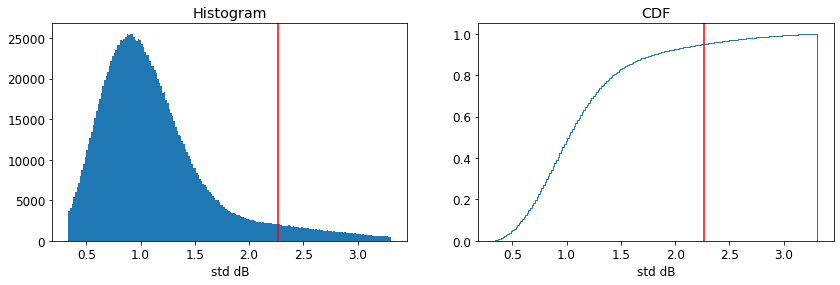

In [34]:
plot_histogram_cdf(metric='std')

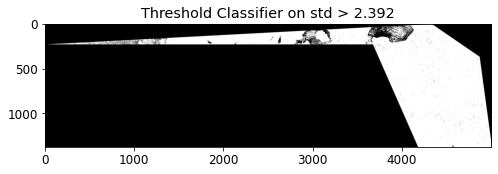

In [35]:
metric = 'std'
masks[metric] = plot_threshold_classifier(metric=metric)

### 6.2 Change Detection with the Coefficient of Variation Method

We can also set a threshold $t$ for the **coefficient of variation image**
to classify change in the time series:
    
${CV}_{x,y} = \frac{\sigma_{x,y}}{\overline{X}_{x,y}} > t$ 

Let's look at the histogram and the Cumulative Distribution Function (CDF) of the coefficient of variation: 

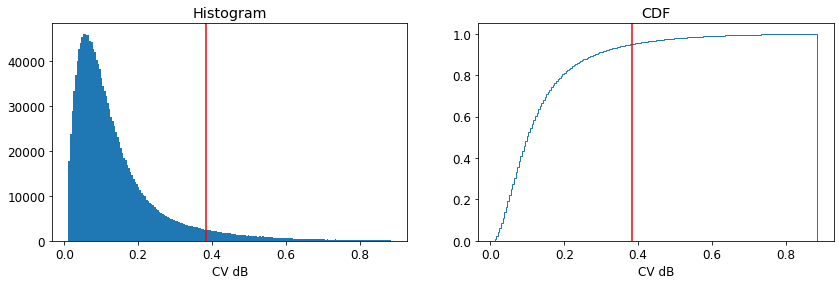

In [36]:
plot_histogram_cdf(metric='CV')

With a threshold of $t=CDF_{CV} > 0.95$ (5% pixels with highest variance) the change pixels would look like the following image:

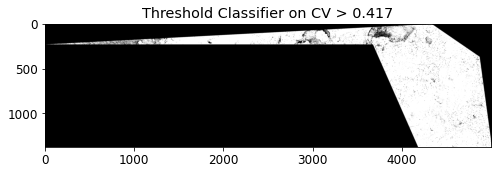

In [37]:
metric = 'CV'
masks[metric] = plot_threshold_classifier(metric=metric)

### 6.3 Pair-wise change detection

To analyze temporal changes between two images, it is useful to compute metrics that are sensitive to discrepancies between the two images. In radar remote sensing, the standard way is to look at ratios (in the linearly scaled power domain) or, equivalently, at differences in the logarithmic dB domain. 

In [38]:
dates = ('2018-05-27', '2018-06-08') # around first eruption

# convert to datetime objects
dates_ = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# get the indices in one line
dates_ind = [np.argmin(np.abs(date - tindex)) for date in dates_]
print(f'Comparing image {dates_ind[0]} from {tindex[dates_ind[0]].date()} with {dates_ind[1]} from {tindex[dates_ind[1]].date()}')

Comparing image 0 from 2021-10-22 with 0 from 2021-10-22


**Compute the log ratio in dB**, corresponding to the difference in dB

In [39]:
ratiodB = 10 * np.ma.log10(np.ma.divide(rasterstack[dates_ind[1], ...], rasterstack[dates_ind[0], ...]))

**Let us manually choose a threshold this time**

thresh is the threshold, e.g. -2 dB

thresh_type determines whether we mask everything below that (lower) or above (upper)

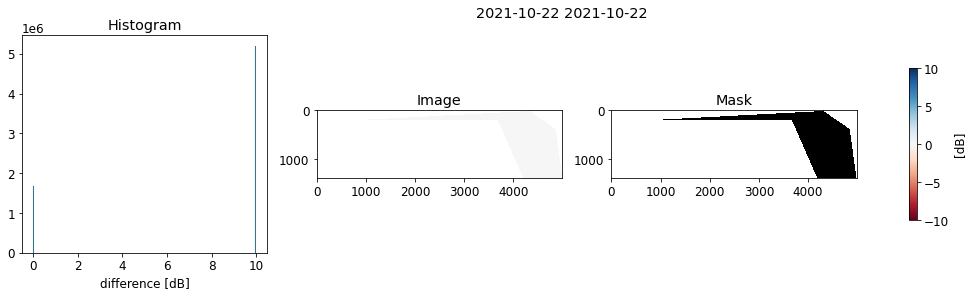

In [40]:
thresh = -2
thresh_type = 'lower' #'lower': mask everything below thresh, 'upper': mask everything above

copy_absRatiod = np.copy(np.abs(ratiodB))
# dynamic_range = np.nanpercentile(np.abs(ratiodB), 99)
dynamic_range = np.nanpercentile(copy_absRatiod, 99)
fig, axs = plt.subplots(ncols=3, nrows=1)
fig.set_size_inches(20, 4)
plt.subplots_adjust(hspace=0.4, right=0.85)

# h = axs[0].hist(
#         ratiodB.flatten(), bins=200, range=np.nanpercentile(ratiodB, [0.1, 99.9]))

h = axs[0].hist(
        ratiodB.flatten(), bins=200, range=np.nanpercentile(np.copy(ratiodB), [0.1, 99.9]))

axs[0].xaxis.set_label_text(f'difference [dB]')
axs[0].set_title('Histogram')
im0 = axs[1].imshow(ratiodB, cmap='RdBu', vmin=-dynamic_range, vmax=dynamic_range)
cbar = fig.colorbar(im0, orientation='vertical', ax=axs.ravel().tolist(), shrink=0.7)
cbar.set_label('[dB]')
axs[1].set_title('Image')
mask = (ratiodB > thresh if thresh_type == 'lower' else ratiodB < thresh).astype(np.int8)
axs[2].imshow(mask, cmap='gray')
axs[2].set_title('Mask')
fig.suptitle(f'{tindex[dates_ind[0]].date()} {tindex[dates_ind[0]].date()}')
logratiolabel = f'logratio_{tindex[dates_ind[0]].date()}_{tindex[dates_ind[0]].date()}'
plt.savefig(product_path/f'{logratiolabel}.png',
            dpi=200, transparent='true')
masks[logratiolabel] = np.logical_not(mask)

**Do you think the threshold is appropriate? If not, try adjusting it.**

---

## 7. Write Our Change Detection Results and Metrics Images to GeoTIFF files

### 7.1 Determine Output Geometry

First, we need to **set the correct geotransformation and projection information**. We retrieve the values from the input images:

In [41]:
proj=img.GetProjection()
geotrans=list(img.GetGeoTransform())
geotrans

[503160.0, 30.0, 0.0, 6107340.0, 0.0, -30.0]

### 7.2 Output Time Series Metrics Images

We use the root of the time series data stack name and append a _ts_metrics_&lt;metric&gt;.tif ending as filenames:

In [42]:
# Time Series Metrics as image:
# We make a new subdirectory where we will store the images

dirname = analysis_dir/f"{str(analysis_dir).split('/')[-1]}_tsmetrics_{pol}"
if not dirname.exists():
    dirname.mkdir()

print(dirname)

/home/jovyan/notebooks/SAR_Training/English/Master/northern_ireland/northern_ireland_tsmetrics_VV


Now we can **output the individual metrics as GeoTIFF images**:

In [43]:
names=[] # List to keep track of all the names
for metric in metrics:
    name_ = dirname/f'{metric}_{labeldB}.tif'
    create_geotiff(str(name_), metrics[metric], gdal.GDT_Float32, np.nan, [metric],
                  geo_t=geotrans, projection=proj)
    names.append(str(name_))

### 7.3 Build a Virtual Raster Table on the Metrics GeoTIFF images

To tie the images into one new raster stack of time series metrics we build a virtual raster table with all the metrics. 

Trick: Use ' '.join(names) to build one long string of names separated by a space as input to *gdalbuildvrt*:

In [44]:
cmd=f'gdalbuildvrt -separate -overwrite -vrtnodata nan {str(dirname)}' +\
f'_{labeldB}.vrt '+' '.join(names)
print(cmd)

_ = system(cmd)

gdalbuildvrt -separate -overwrite -vrtnodata nan /home/jovyan/notebooks/SAR_Training/English/Master/northern_ireland/northern_ireland_tsmetrics_VV_dB.vrt /home/jovyan/notebooks/SAR_Training/English/Master/northern_ireland/northern_ireland_tsmetrics_VV/mean_dB.tif /home/jovyan/notebooks/SAR_Training/English/Master/northern_ireland/northern_ireland_tsmetrics_VV/max_dB.tif /home/jovyan/notebooks/SAR_Training/English/Master/northern_ireland/northern_ireland_tsmetrics_VV/min_dB.tif /home/jovyan/notebooks/SAR_Training/English/Master/northern_ireland/northern_ireland_tsmetrics_VV/range_dB.tif /home/jovyan/notebooks/SAR_Training/English/Master/northern_ireland/northern_ireland_tsmetrics_VV/median_dB.tif /home/jovyan/notebooks/SAR_Training/English/Master/northern_ireland/northern_ireland_tsmetrics_VV/p5_dB.tif /home/jovyan/notebooks/SAR_Training/English/Master/northern_ireland/northern_ireland_tsmetrics_VV/p95_dB.tif /home/jovyan/notebooks/SAR_Training/English/Master/northern_ireland/northern_i

### 7.4 Create GeoTIFFs for the Change Iamges from our Four Change Detection Attempts

We are going to write GeoTIFF output files that stores the results from the classifiers:

In [45]:
for metric in masks:  
    fnmetric = dirname/f"{str(analysis_dir).split('/')[-1]}_{labeldB}_{metric}_thresholds.tif"
    print(fnmetric)

    create_geotiff(str(fnmetric), masks[metric], gdal.GDT_Byte, np.nan, 
                  geo_t=geotrans, projection=proj)

/home/jovyan/notebooks/SAR_Training/English/Master/northern_ireland/northern_ireland_tsmetrics_VV/northern_ireland_dB_prange_thresholds.tif
/home/jovyan/notebooks/SAR_Training/English/Master/northern_ireland/northern_ireland_tsmetrics_VV/northern_ireland_dB_std_thresholds.tif
/home/jovyan/notebooks/SAR_Training/English/Master/northern_ireland/northern_ireland_tsmetrics_VV/northern_ireland_dB_CV_thresholds.tif
/home/jovyan/notebooks/SAR_Training/English/Master/northern_ireland/northern_ireland_tsmetrics_VV/northern_ireland_dB_logratio_2021-10-22_2021-10-22_thresholds.tif


*SARChangeDetectionMethods_From_Prepared_Data_Stack - Version 1.4.2 - November 2021*

*Version Changes*

- *asf_notebook -> opensarlab_lib*
- *html -> markdown*
- *remove old Exercise cells*
- *url-widget*